In [1]:
import ast
from collections import defaultdict
import json
import os
import sys
import time

import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit

sys.path.append('..')  # add parent directory to path
from src.wildfire_statistics import (
    make_weighted_disturbance_pdf,
    fit_wildfire_statistics,
    exp_sum_stats
)

%matplotlib inline

In [2]:
gpd.__version__

'0.9.0'

## Data wrangling

In [3]:
# Parameters

# Different spatial units can be considered
# spatial_type = 'Ecozone'
# eco_unit_column = 'ECOZONE_ID'
# eco_unit_example = 'Taiga plains'

# spatial_type = 'Ecoprovince'
# eco_unit_column = 'ECOPROVINCE_ID'
# eco_unit_example = 'Taiga plains'

spatial_type = 'Ecoregion'
eco_unit_column = 'ECOREGION_ID'
eco_unit_example = 65

In [4]:
start = time.time()

# we can speed up the load time if we persist using feather
file_path='../data/raw/nbac.feather'
if os.path.exists(file_path):
    burn_area_df = gpd.read_feather(file_path)
else:
    burn_area_df = gpd.read_file('../data/raw/nbac/nbac_1986_to_2019_20200921.shp')
    burn_area_df.to_feather(file_path)

eco_units = gpd.read_feather(f'../data/raw/{spatial_type.lower()}s_area.feather')
# ecozone name map, e.g. {'1': 'Arctic'}
if spatial_type == 'Ecozone':
    with open('../data/raw/ecozones_name.json', 'r') as fp:
        ecozone_names = json.load(fp)

    # convert string keys to int
    ecozone_names = dict([int(a), x] for a, x in ecozone_names.items())
    eco_units = eco_units.replace({eco_unit_column: ecozone_names})

minutes = (time.time() - start)/60
print(f'time in minutes: {minutes}')

time in minutes: 0.5805126746495565


In [5]:
eco_units.head(1)

,OBJECTID,ECOREGION_ID,TOTAL_AREA,LAND_AREA,WATER_AREA,geometry
0,1,1,1.129173e+07,1.128505e+07,6679.000771,"MULTIPOLYGON (((-8147857.449 14783263.384, -81..."


In [6]:
burn_area_df.head(1)

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,AFEDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLG,AGENCY,BT_GID,VERSION,COMMENTS,geometry
0,1986.0,54.0,1.0,9.0,7.0,0.0,4.0,None,None,1986-05-22,1986-06-28,1986-08-19,4099.013447,4099.013447,0.0,ON,1.0,1986_r9_20200921,Null,"MULTIPOLYGON (((162710.000 456311.344, 162680...."


In [7]:
start = time.time()

eco_units = eco_units.to_crs(burn_area_df.crs)
eco_units_burned = gpd.tools.sjoin(
    eco_units,
    burn_area_df,
    how="right", op='intersects')

eco_units_burned['LAND_AREA_FRACTION'] = eco_units_burned.POLY_HA.values / eco_units_burned.LAND_AREA.values

minutes = (time.time()-start)/60
print(f'{minutes} minutes')

2.424302605787913 minutes


In [8]:
eco_units_burned.head(1)

,index_left,OBJECTID,ECOREGION_ID,TOTAL_AREA,LAND_AREA,WATER_AREA,YEAR,NFIREID,BASRC,FIREMAPS,...,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLG,AGENCY,BT_GID,VERSION,COMMENTS,geometry,LAND_AREA_FRACTION
0,88,89,89,1.416754e+07,1.092984e+07,3.237692e+06,1986.0,54.0,1.0,9.0,...,1986-08-19,4099.013447,4099.013447,0.0,ON,1.0,1986_r9_20200921,Null,"MULTIPOLYGON (((162710.000 456311.344, 162680....",0.000375


In [9]:
annual_stats = eco_units_burned[[eco_unit_column, 'YEAR', 'LAND_AREA_FRACTION', 'POLY_HA']].groupby([eco_unit_column, 'YEAR']).sum()
annual_stats = annual_stats.reset_index()

annual_stats.head(1)

,ECOREGION_ID,YEAR,LAND_AREA_FRACTION,POLY_HA
0,33,2003.0,0.000807,1241.817142


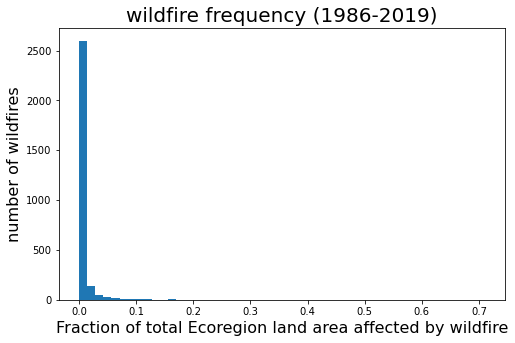

In [10]:
year_min = int(annual_stats.YEAR.min())
year_max = int(annual_stats.YEAR.max())
plt.figure(figsize=(8,5))
plt.ylabel('number of wildfires', size=16)
plt.xlabel(f"Fraction of total {spatial_type} land area affected by wildfire", size=16)
plt.title(f'wildfire frequency ({year_min}-{year_max})', size=20)
_ = plt.hist(annual_stats.LAND_AREA_FRACTION, bins=50)
plt.savefig(f'../figures/wildfire-frequency-{spatial_type.lower()}', dpi=150)

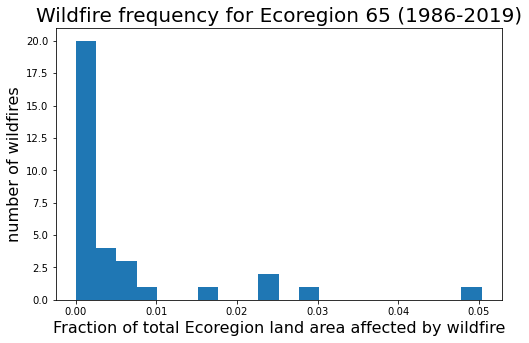

In [11]:
year_min = int(annual_stats.YEAR.min())
year_max = int(annual_stats.YEAR.max())
ecoregion_annual_stats = annual_stats[
    annual_stats[eco_unit_column]==eco_unit_example].LAND_AREA_FRACTION

plt.figure(figsize=(8,5))
plt.ylabel('number of wildfires', size=16)
plt.xlabel(f"Fraction of total {spatial_type} land area affected by wildfire", size=16)
plt.title(f"Wildfire frequency for {spatial_type} {eco_unit_example} ({year_min}-{year_max})", size=20)
_ = plt.hist(ecoregion_annual_stats, bins=20)
plt.savefig(f'../figures/wildfire-frequency-{spatial_type.lower()}-{eco_unit_example}', dpi=150)

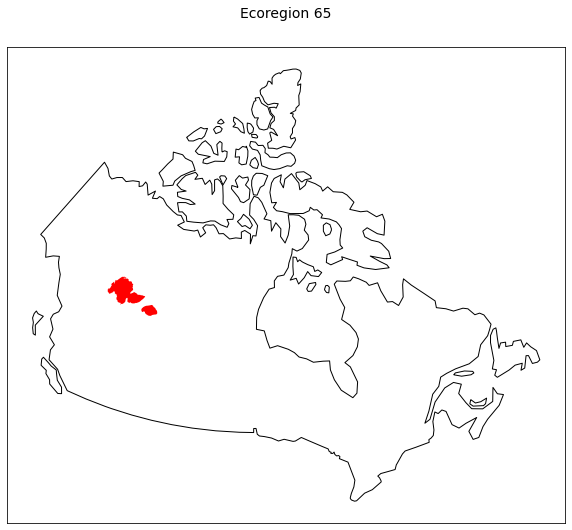

In [12]:
f, ax = plt.subplots(1, figsize=(10, 10))
plt.title(
    f'{spatial_type} {eco_unit_example}',
    y=1.05,
    fontdict={'fontsize':14})
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

eco_unit_boundary = eco_units[eco_units[eco_unit_column] == eco_unit_example]

eco_unit_map = eco_unit_boundary.plot(
    ax=ax,
    color='red')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.to_crs(burn_area_df.crs)
Canada = world[world.name=='Canada']
_ = Canada.plot(
    ax=eco_unit_map,
    facecolor='none',
    edgecolor='black',
)
plt.savefig(f'../figures/{spatial_type.lower()}_{eco_unit_example}.png')

In [13]:
annual_stats.head(1)

,ECOREGION_ID,YEAR,LAND_AREA_FRACTION,POLY_HA
0,33,2003.0,0.000807,1241.817142


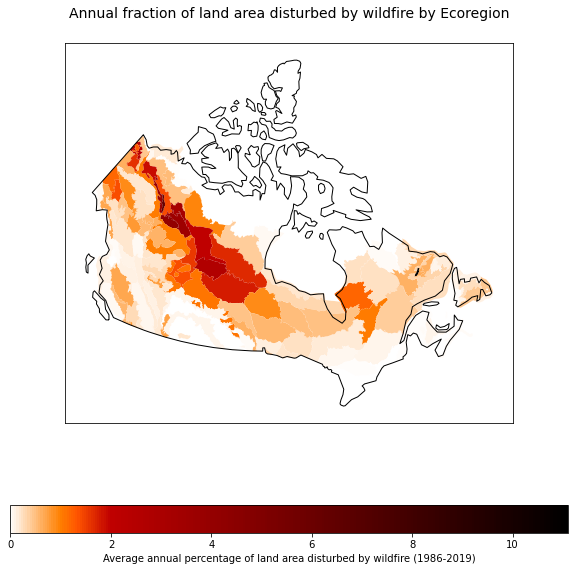

In [14]:
mean_annual_stats = annual_stats[[eco_unit_column,'LAND_AREA_FRACTION']].groupby(eco_unit_column).mean()
annual_stats = annual_stats.reset_index()
eco_units_disturbance = eco_units.merge(mean_annual_stats, on=eco_unit_column)

eco_units_disturbance['LAND_AREA_PERCENT'] = eco_units_disturbance['LAND_AREA_FRACTION']*100

years = annual_stats.YEAR.unique()
year_min = int(years.min())
year_max = int(years.max())
years_range = f'{year_min}-{year_max}'

f, ax = plt.subplots(1, figsize=(10, 10))
plt.title(
    f'Annual fraction of land area disturbed by wildfire by {spatial_type}',
    y=1.05,
    fontdict={'fontsize':14})
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

# normalize color
vmin = 0
vmax = eco_units_disturbance.LAND_AREA_PERCENT.max()
vcenter = 2
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

disturbance_map = eco_units_disturbance.plot(
    ax=ax,
    column='LAND_AREA_PERCENT',
    cmap= 'gist_heat_r', # 'Reds',
    norm=norm,
    legend=True,
    legend_kwds={
        'label': f"Average annual percentage of land area disturbed by wildfire ({years_range})",
        'orientation': "horizontal"})

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.to_crs(burn_area_df.crs)
Canada = world[world.name=='Canada']
_ = Canada.plot(
    ax=disturbance_map,
    facecolor='none',
    edgecolor='black',
)
    
plt.savefig(f'../figures/wildfire-statistics_{spatial_type.lower()}', dpi=150)

In [15]:
def get_ecounit_statistics(annual_stats, eco_unit_column):
    time_horizon_average = defaultdict()
    min_area = defaultdict()
    average_area = defaultdict()
    max_time_horizon = defaultdict()
    for eco_unit in annual_stats[eco_unit_column].unique():
        eco_unit_land_fraction = annual_stats[annual_stats[eco_unit_column]==eco_unit].LAND_AREA_FRACTION
        time_horizon_average[eco_unit] = [1/eco_unit_land_fraction.mean()]
        min_area[eco_unit] = eco_unit_land_fraction.min()
        average_area[eco_unit] = eco_unit_land_fraction.mean()
        max_time_horizon[eco_unit] = [1/eco_unit_land_fraction.min()]
    return time_horizon_average, min_area, average_area, max_time_horizon

(time_horizon_average,
 min_area,
 average_area,
 max_time_horizon) = get_ecounit_statistics(annual_stats, eco_unit_column)

average disturbance time


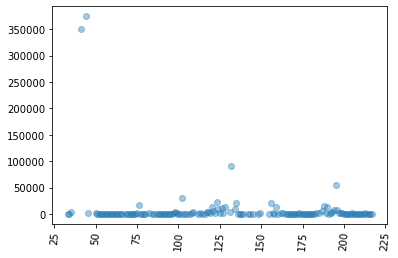

In [16]:
print('average disturbance time')
df = pd.DataFrame(time_horizon_average)
plt.scatter(x=df.columns, y=df.values, alpha=0.4)
_ = plt.xticks(rotation = 85)

average disturbance time


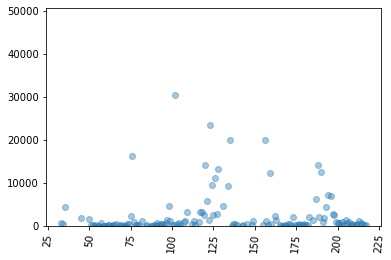

In [17]:
print('average disturbance time')
df = pd.DataFrame(time_horizon_average)
fig = plt.scatter(x=df.columns, y=df.values, alpha=0.4)
fig.axes.set_ylim([0, df.values.mean() + df.values.std()])
_ = plt.xticks(rotation = 85)

In [18]:
annual_stats.head(1)

,index,ECOREGION_ID,YEAR,LAND_AREA_FRACTION,POLY_HA
0,0,33,2003.0,0.000807,1241.817142


## Generating temporal probability density functions from wildfire statistics

We can use the statistics above about the fraction of land annually disturbed by fire to generate a probabillity density function describing the probablility that a unit of land will be disturbed by fire at time t. If the fraction of land area annually distrubed by wildore ($annualAreaDisturbed$) of total land area disturbed by wildfire in year n is 1%, it would take t = 1/0.01 years for an area of land equivalent to the entire land area to be disturbed. This can described using a uniform probability density function: 

$$ disturbancePDF_{year}(t) \sim U(0, 1/annualAreaDisturbed_{year})$$.

Summing uniform PDFs generated from annual disturbance statistics and re-normalizing generates an empirically bas PDF of wildfire disturbance:

$$aggregatedDisturbancePDF(t) = \sum^{year} disturbancePDF_{year}(t)$$


$$weightedDisturbancePDF(t) = \frac{aggregatedDisturbancePDF(t)}{\sum^t aggregatedDisturbancePDF(t)}$$

# Example application for an individual spatial unit

In [19]:
# create hist data
ecounit_subset = annual_stats[annual_stats[eco_unit_column]==eco_unit_example]
hist = np.histogram(ecounit_subset.LAND_AREA_FRACTION, bins=40, density=True)
hist_dist = stats.rv_histogram(hist)

uniform_pdf, x_range = make_weighted_disturbance_pdf(ecounit_subset.LAND_AREA_FRACTION)
params, cov = curve_fit(
    exp_sum_stats,
    xdata=x_range,
    ydata=uniform_pdf,
    bounds=((0., 1., 1.), (1., np.inf, np.inf)))
print('w: {:.2f}; scale1: {:.2f}; scale2: {:.2f}'.format(*params))
params_sd = np.sqrt(np.diag(cov))
print('sd w: {:.2f}; sd scale1: {:.2f}; sd scale2: {:.2f}'.format(*params_sd))
print(f'samples: {ecounit_subset.LAND_AREA_FRACTION.shape[0]}')

minimum annual fraction of area disturbed: 7.238786213154477e-07
w: 0.62; scale1: 2057.10; scale2: 61.16
sd w: 0.00; sd scale1: 2.37; sd scale2: 0.03
samples: 33


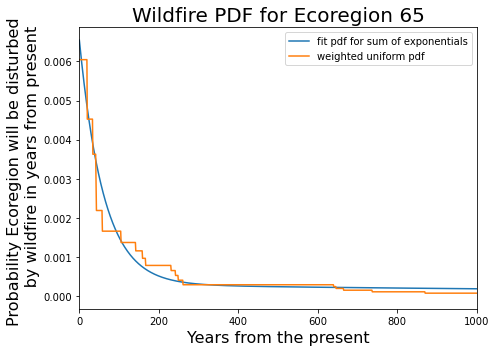

In [20]:
x_lim = 10000
x = np.arange(x_lim)
fit_exp_sum = exp_sum_stats(x, *params)

plt.figure(figsize=(7,5))
plt.xlim(0, 1000)
plt.title(f"Wildfire PDF for {spatial_type} {eco_unit_example}", size=20)
plt.xlabel("Years from the present", size=16)
plt.ylabel(f"Probability {spatial_type} will be disturbed \n \
    by wildfire in years from present", size=16)
plt.plot(x, fit_exp_sum, label='fit pdf for sum of exponentials')
plt.plot(x_range, uniform_pdf, label='weighted uniform pdf')

_ = plt.legend()
plt.tight_layout()
plt.savefig(f'../figures/pdf-{spatial_type.lower()}-{eco_unit_example}', dpi=150)

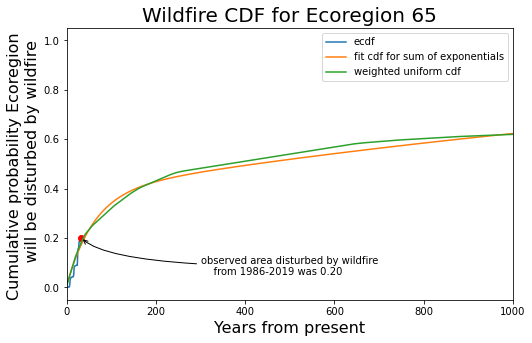

In [21]:
xlim = 10000
x = np.arange(xlim)
y_ecdf = np.cumsum(ecounit_subset.LAND_AREA_FRACTION)
x_ecdf = range(len(y_ecdf))
cumulative_area_disturbed_ecounit = ecounit_subset.LAND_AREA_FRACTION.sum()
cumulative_years = ecounit_subset.YEAR.max() - ecounit_subset.YEAR.min()

plt.figure(figsize=(8,5))
plt.xlim(0, 1000)

plt.plot(x_ecdf, y_ecdf, label='ecdf')
plt.plot(x_ecdf[-1], y_ecdf.values[-1], c='red', marker='o')
plt.annotate(
    'observed area disturbed by wildfire \n\
    from {}-{} was {:.2f}'.format(
        int(ecounit_subset.YEAR.min()),
        int(ecounit_subset.YEAR.max()),
        y_ecdf.values[-1]
    ),
    xy=(cumulative_years, cumulative_area_disturbed_ecounit),
    xytext=(300, 0.05),
    arrowprops=dict(arrowstyle="->",
    connectionstyle="angle3,angleA=0,angleB=-45"))

plt.plot(x, np.cumsum(fit_exp_sum), label='fit cdf for sum of exponentials')
plt.plot(x_range, np.cumsum(uniform_pdf), label='weighted uniform cdf')
plt.title(f"Wildfire CDF for {spatial_type} {eco_unit_example}", size=20)
plt.xlabel("Years from present", size=16)
plt.ylabel(f"Cumulative probability {spatial_type} \n \
    will be disturbed by wildfire", size=16)
_ = plt.legend()

# plt.tight_layout()
plt.savefig(f'../figures/cdf-{spatial_type.lower()}-{eco_unit_example}', dpi=150)

In [22]:
years = len(ecounit_subset.LAND_AREA_FRACTION)
print(f"Actual statistics for {spatial_type} {eco_unit_example}")
print(f'years: {years}')
print(f'Average annual land area affected by wildfire: {ecounit_subset.LAND_AREA_FRACTION.mean():.2%}')
print(f'Actual cumulative land area affected by wildfire over {years} years: {ecounit_subset.LAND_AREA_FRACTION.sum():.2%}')
print('-----------')
print('Estimated statistics')
print(f'Estimated cumulative land area affected by wildfire over {years} years: {np.cumsum(fit_exp_sum)[years-1]:.2%}')

Actual statistics for Ecoregion 65
years: 33
Average annual land area affected by wildfire: 0.61%
Actual cumulative land area affected by wildfire over 33 years: 20.01%
-----------
Estimated statistics
Estimated cumulative land area affected by wildfire over 33 years: 17.04%


## Applying the approach across all spatial units

In [23]:
try:
    result = pd.read_csv(f'../data/results/pdf_params_{spatial_type}.csv', index_col=0).to_dict()
except FileNotFoundError:
    # This will take a while to compute
    result = fit_wildfire_statistics(annual_stats)
    pd.DataFrame.from_dict(result).to_csv(f'../data/results/pdf_params_{spatial_type}.csv')

## Visualizing a sample of the results

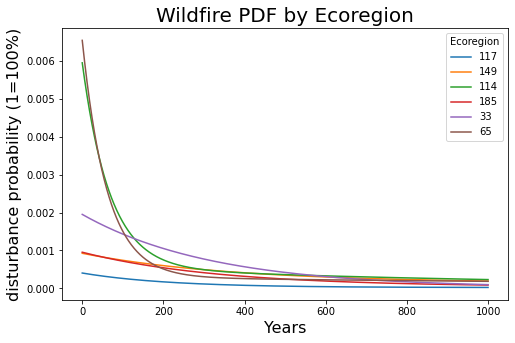

In [24]:
xlim = 1000
x = np.arange(xlim)
random_ids = np.random.choice(list(result.keys()), 5, replace=False)
random_ids = np.append(random_ids, str(eco_unit_example))

plt.figure(figsize=(8,5))
plt.title(f"Wildfire PDF by {spatial_type}", size=20)
plt.xlabel("Years", size=16)
plt.ylabel("disturbance probability (1=100%)", size=16)

for region in random_ids:
    # reading a dictionary from it's string representation
    params_ = ast.literal_eval(result[region]['params'])
    samples = result[region]['samples']
    pdf = exp_sum_stats(x, params_['w'], params_['scale1'], params_['scale2'])
    plt.plot(range(len(pdf)), pdf, label=str(region))
    
_ = plt.legend(title=f"{spatial_type}")
plt.savefig(f'../figures/pdf-{spatial_type.lower()}', dpi=150)

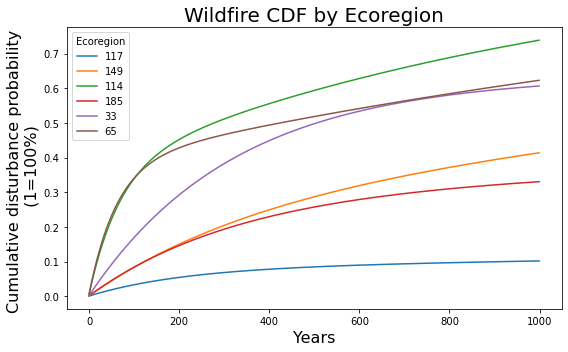

In [25]:
xlim = 1000
x = np.arange(xlim)

plt.figure(figsize=(8,5))
plt.title(f"Wildfire CDF by {spatial_type}", size=20)
plt.xlabel("Years", size=16)
plt.ylabel("Cumulative disturbance probability \n (1=100%)", size=16)

for region in random_ids:
    # reading a dictionary from it's string representation
    params_ = ast.literal_eval(result[region]['params'])
    samples = result[region]['samples']
    pdf = exp_sum_stats(x, params_['w'], params_['scale1'], params_['scale2'])
    plt.plot(range(len(pdf)), np.cumsum(pdf), label=str(region))
    
_ = plt.legend(title=f"{spatial_type}")
plt.tight_layout()
plt.savefig(f'../figures/cdf-{spatial_type.lower()}', dpi=150)